# Notes

- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.

# Imports

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utility functions

In [112]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}

def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, map_group_to_marker = map_group_to_marker, xlim = None):
    groups = df.groupby('role')

    fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    plt.show()
    return ax

# Read in data

In [109]:
%%time
df_users = pd.read_csv('data/ml-seattle-stats.csv') 

Wall time: 10 ms


In [110]:
# Remove users who have audited < 0 meters
print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)

# add in labels per meter
df_users['labels_per_meter'] = df_users['label_count'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

The following indices have meters_audited < 0: Int64Index([435], dtype='int64')


In [123]:
df_users.sample(10)

,user_id,role,validation_count,accuracy,audit_mission_count,validation_mission_count,meters_audited,label_count,labels_per_meter
122,3f23e080-7bfa-4e8c-8a43-ef9a5b832f84,Turker,23,65.217391,1,0,207.679977,24,0.115562
457,dd10a183-4ec6-4d5b-ba1e-160bf00f29d4,Turker,43,62.790698,3,0,583.899452,48,0.082206
167,588b8e51-3029-41c4-b38b-f449feb578f5,Registered,125,70.400000,3,6,457.199982,68,0.148731
369,b267facb-5465-4aa0-9890-80ca03b90275,Turker,25,56.000000,3,0,584.718666,34,0.058148
357,af692260-8014-4357-8aba-9f479bf51482,Anonymous,33,90.909091,3,0,533.399994,21,0.039370
269,88e2440e-91b8-4f6b-86a0-db79172dfa65,Anonymous,32,84.375000,3,3,533.399994,34,0.063742
404,c999700a-b593-41f2-89d7-9650e04068dc,Turker,15,100.000000,1,0,256.069527,17,0.066388
43,19735043-3130-4bb5-aa56-ba1a505b9240,Turker,27,74.074074,1,0,275.052116,30,0.109070
45,19ce7bb2-1ef5-4904-9582-67a2b567cd29,Registered,308,59.740260,4,7,841.693049,112,0.133065
114,3c6e435f-a183-40b4-a880-9e2adbc8f671,Turker,1,0.000000,1,0,232.842705,1,0.004295


# Exploratory analysis

In [103]:
df_users.groupby('role').describe()

validation_count                                             \
                      count        mean         std  min    25%    50%   
role                                                                     
Anonymous             200.0   15.990000   15.151161  1.0   6.00   12.0   
Registered            158.0  123.721519  301.074083  1.0  24.00   50.5   
Researcher              8.0  736.000000  816.847599  8.0  47.75  436.0   
Turker                159.0  166.062893  506.401623  1.0  11.00   22.0   

                            accuracy             ... label_count          \
                75%     max    count       mean  ...         75%     max   
role                                             ...                       
Anonymous     21.00   119.0    200.0  74.441300  ...       19.00    99.0   
Registered   111.50  2997.0    158.0  70.301079  ...       67.25  8588.0   
Researcher  1363.75  1894.0      8.0  71.868358  ...      866.75  1191.0   
Turker        42.50  3730.0    159.0  67.524919  ...       49.50  7179.0   

           labels_per_meter                                                    \
                      count      mean       std       min       25%       50%   
role                                                                            
Anonymous             200.0  0.101147  0.319605  0.000000  0.026247  0.059134   
Registered            158.0  0.082083  0.049574  0.002540  0.047809  0.074307   
Researcher              8.0  0.104744  0.068891  0.030993  0.062210  0.089837   
Turker                159.0  0.059711  0.044145  0.000673  0.027501  0.052022   

                                
                 75%       max  
role                            
Anonymous   0.104830  3.880270  
Registered  0.104300  0.353088  
Researcher  0.125242  0.254031  
Turker      0.080727  0.235220  

[4 rows x 56 columns]

In [104]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=True))

,user_id,role,validation_count,accuracy,audit_mission_count,validation_mission_count,meters_audited,label_count,labels_per_meter
374,b474c355-579c-4774-ac98-ca5079ca2517,Anonymous,11,90.909091,1,0,0.000000,10,0.000000
110,3bc42e7e-81f2-4df3-ad2b-6db92dfc784e,Turker,1,0.000000,11,0,2971.799896,2,0.000673
300,97a1e398-8d74-4b46-b203-a206f7a0df6c,Turker,1,100.000000,6,0,1438.147705,1,0.000695
432,d5851bbf-a97c-4736-822a-0820d39be69a,Turker,4,50.000000,5,0,1194.647095,2,0.001674
13,09ab27fe-344f-4aa1-a7ed-070e1e3155f0,Turker,2,50.000000,2,0,489.305054,1,0.002044
204,6dcd986c-fdd9-44ab-9725-e5c7d557b451,Registered,41,63.414634,9,12,2362.199921,6,0.002540
15,0b5e9da1-aea2-4b54-964f-d321f2c35af8,Anonymous,1,0.000000,2,6,352.094833,1,0.002840
278,8afc67d1-7c38-4f79-877e-fc3fab0995c7,Anonymous,4,25.000000,11,3,2968.115509,9,0.003032
106,390650c0-5c69-405e-91e4-d6e234a3e1f4,Turker,3,66.666667,3,0,640.118179,2,0.003124
48,1ad1e234-d2b7-425a-af47-11a6e233d980,Registered,1,0.000000,2,0,304.799988,1,0.003281


In [105]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False))

,user_id,role,validation_count,accuracy,audit_mission_count,validation_mission_count,meters_audited,label_count,labels_per_meter
1,008d2723-1b96-4a51-9ffb-c4826564b352,Anonymous,4,100.000000,1,0,1.675323,4,2.387599
287,9128677a-9543-4d2d-861f-0c649a3dcc88,Anonymous,1,100.000000,1,1,152.399994,32,0.209974
376,b6cfb689-324a-4d27-8e0e-7a98c543936c,Registered,21,100.000000,1,0,152.399994,26,0.170604
325,a0c7baaa-c99d-40e3-8a68-9f19b707191e,Anonymous,1,100.000000,1,3,152.399994,18,0.118110
12,096e5e83-a652-4733-9743-05b67f3fe3c2,Registered,8,100.000000,3,12,533.399994,58,0.108736
309,9ab48ccd-8a95-4a4b-a0dc-90e1e7d709b6,Anonymous,12,100.000000,1,0,152.399994,16,0.104987
91,2f6415e5-f851-4105-afc8-d2fb5f60fc77,Registered,13,100.000000,1,4,152.399994,14,0.091864
283,8fe32410-fafd-4557-91bd-c4bdb7180be0,Anonymous,16,100.000000,1,0,152.399994,14,0.091864
135,45262ae2-5845-4c16-a612-3a42f87bf1ad,Anonymous,12,100.000000,1,1,152.399994,12,0.078740
136,45855ddf-576e-4f3e-a9f4-13b41b48988e,Registered,2,100.000000,2,0,297.482376,23,0.077316


## Scatter plots of features

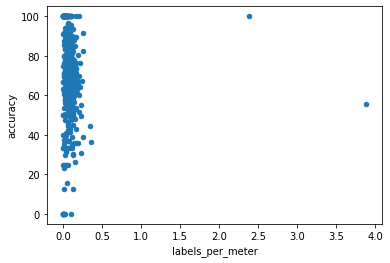

In [106]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

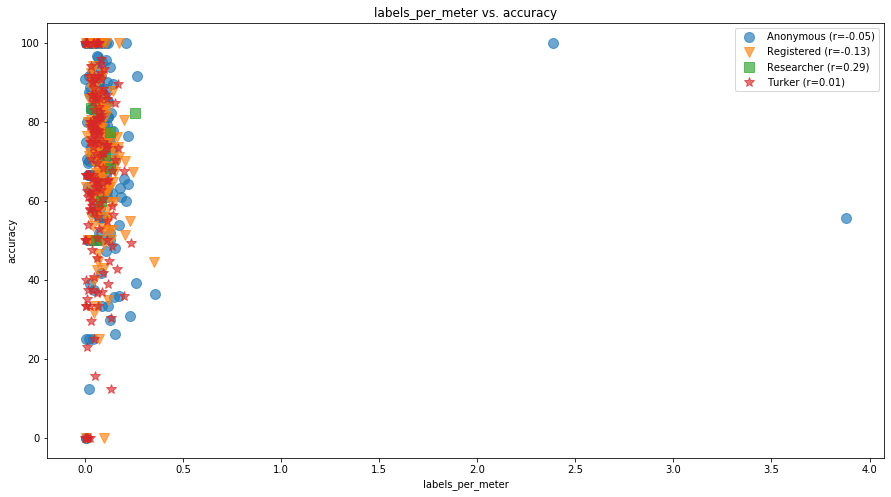

In [113]:
# So I made my own scatter plot
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

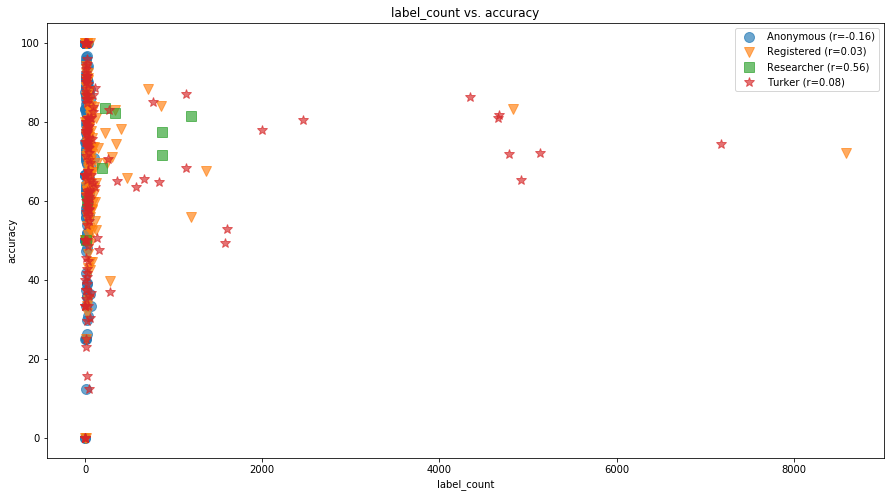

In [114]:
plot_scatter(df_users, 'label_count', 'accuracy');

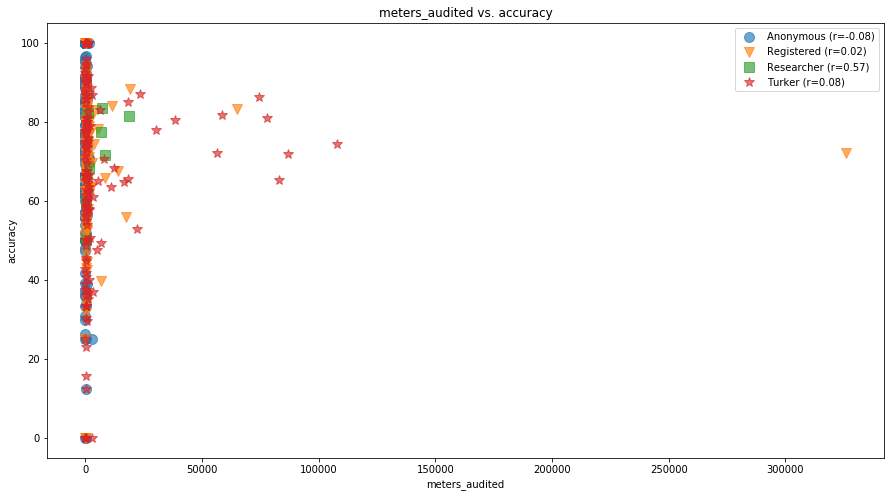

In [115]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

## Pairwise correlations

Text(0.5, 1, 'Pairwise correlation of input features')

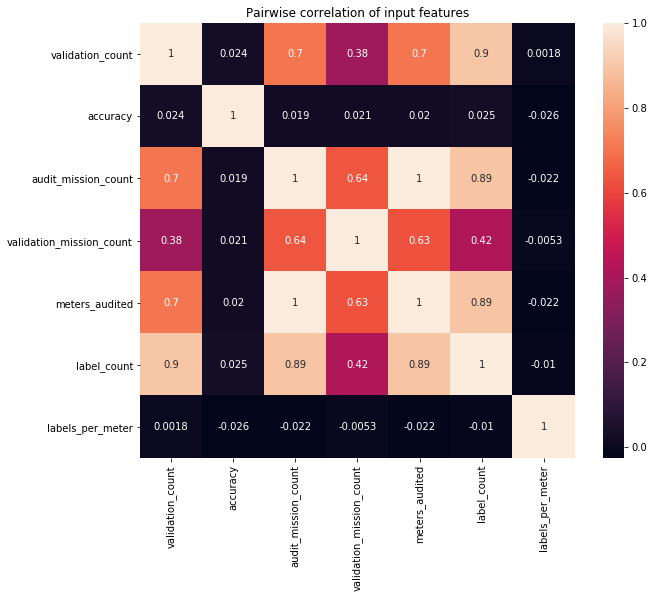

In [118]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

## Pairplots

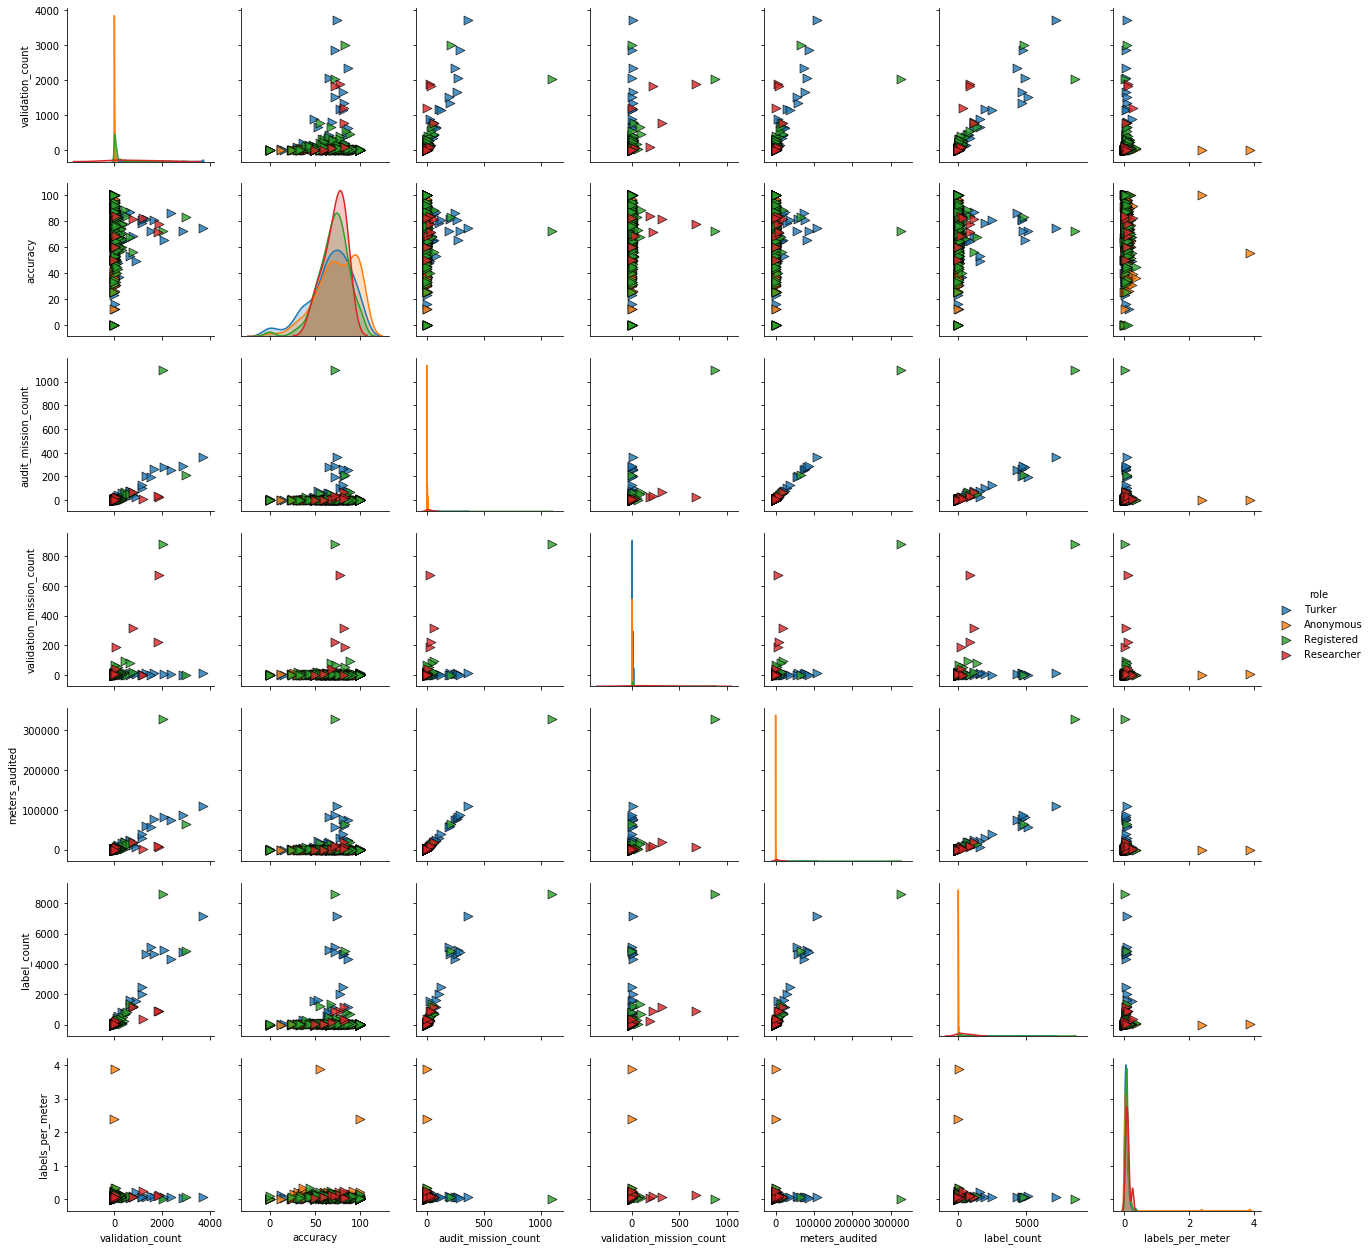

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);